In [55]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle


from scipy.linalg import toeplitz as sp_toeplitz
from scipy.linalg import circulant as sp_circulant

from scipy.sparse.linalg import LinearOperator
from numpy.fft import fft, ifft

from jlinops import CirculantOperator
import jlinops

# From paper

In [61]:
n = 5
t = np.concatenate([np.arange(start=-n, stop=0), np.arange(n)] )
#t = np.concatenate([-np.arange(start=-n, stop=0), np.arange(n)] )
#T = sp_toeplitz(t)

In [62]:
T = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        T[i,j] = t[i-j]

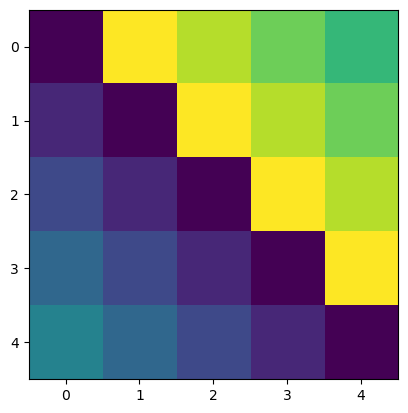

In [63]:
plt.imshow(T)
plt.show()

In [36]:
def eval_s(i, t, n, cval=1.0):
    if i > 0:
        return t[i-n]
    elif i < 0:
        return t[i+n]
    else:
        return cval

In [37]:
S = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        S[i,j] = eval_s(i-j, t, n)

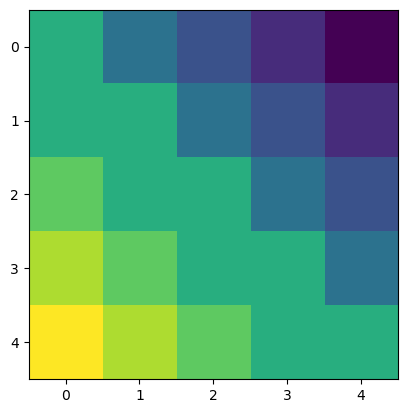

In [38]:
plt.imshow(S)
plt.show()

In [39]:
# Make large matrix
C = np.vstack( [ np.hstack([T, S]), np.hstack([S, T]) ])

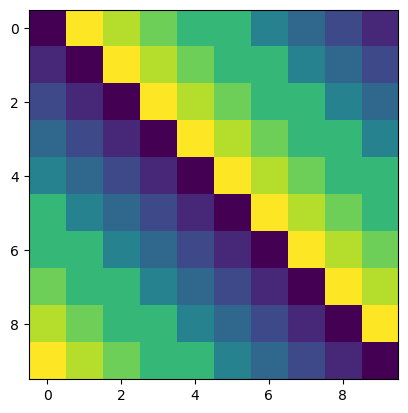

In [40]:
plt.imshow(C)
plt.show()

In [41]:
C.shape

(10, 10)

In [42]:
T.shape

(5, 5)

# In terms of rows/columns

In [85]:
n = 7
t = np.arange(n)
T = sp_toeplitz(t)

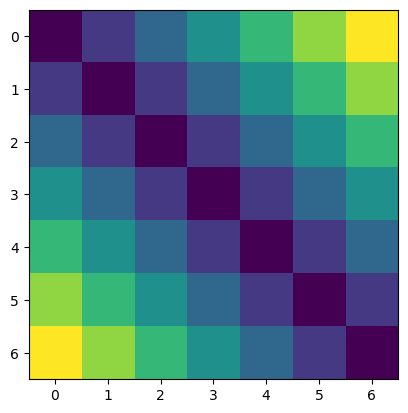

In [86]:
plt.imshow(T)
plt.show()

In [87]:
# Build a circulant matrix this is embedded in
first_row, first_col = T[0,:], T[:,0]
C_first_row = np.concatenate( [first_col,  np.concatenate( [ np.atleast_1d(1.0) ,   np.flip(first_col[1:]) ])   ]    )
C = sp_circulant( C_first_row ).T

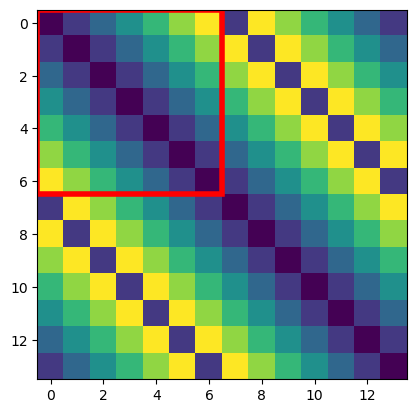

In [88]:
mask = np.zeros_like(C, dtype=bool)
mask[:n,:n] = True  # This creates a rectangular mask

rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
ymin, ymax = np.where(rows)[0][[0, -1]]
xmin, xmax = np.where(cols)[0][[0, -1]]

xmin -= 0.5
ymin -= 0.5
xmax += 0.5
ymax += 0.5

plt.imshow(C)

rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=4, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()

In [47]:
# Check this is correct
assert np.linalg.norm( C[:n,:n] - T  ) < 1e-3, "Not correct!"

# Make a convenience function for later

In [51]:
def symmetric_toeplitz_circulant_embedding(T, cval=1.0, which="matrix"):
    """Given a symmetric Toeplitz matrix T, returns a circulant matrix of double the dimensions 
    that contains T on its upper left submatrix.
    """

    # If 1-dimensional, assume we are getting the first column of T
    if T.ndim == 1:
        first_col = T

    # If 2-dimensinoal, assume we are getting the entire matrix for T
    else:
        first_row, first_col = T[0,:], T[:,0]


    C_first_row = np.concatenate( [first_col,  np.concatenate( [ np.atleast_1d(cval) ,   np.flip(first_col[1:]) ])   ]    )
    if which == "matrix":
        C = sp_circulant( C_first_row )
    else:
        C = CirculantOperator( C_first_row )

    return C

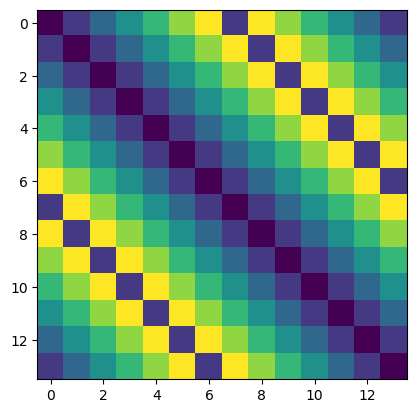

In [53]:
plt.imshow( symmetric_toeplitz_circulant_embedding(T) )
plt.show()

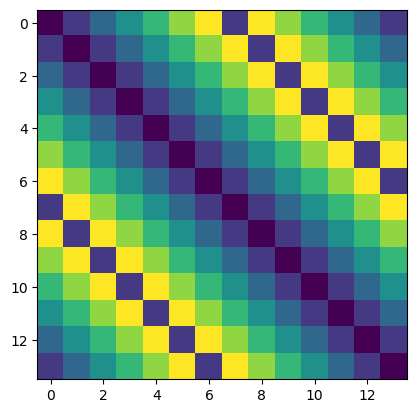

In [50]:
plt.imshow( jlinops.black_box_to_dense( symmetric_toeplitz_circulant_embedding(T, which="operator") ) )
plt.show()

### Awesome! Can we explicitly construct this from block 2 x 2 Toeplitz matrices ?

In [165]:
A1 = jlinops.MatrixLinearOperator(T)
A2 = jlinops.MatrixLinearOperator( sp_toeplitz(np.concatenate( [ np.atleast_1d(1.0) ,   np.flip(first_col[1:]) ])) )
A3 = jlinops.MatrixLinearOperator( A2 )
A4 = jlinops.MatrixLinearOperator( T )
A = jlinops.Block2x2Operator(A1, A2, A3, A4)

In [166]:
Amat = jlinops.black_box_to_dense(A)

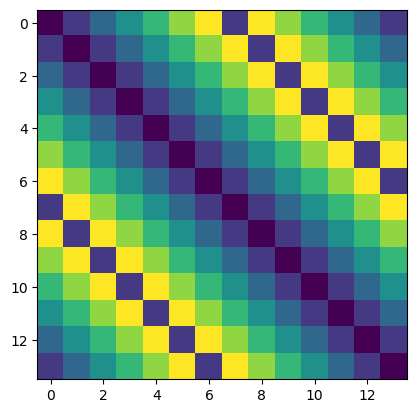

In [167]:
plt.imshow(Amat)
plt.show()

# Can we get the matvec and transpose correct?

In [23]:
n = 7
t = np.arange(n)
T = sp_toeplitz(t)
C = jlinops.toeplitz_circulant_embedding(T)

In [24]:
#np.random.seed(0)
v = np.random.normal(size=n)
v_padded = np.concatenate([v, np.zeros(n)])

In [25]:
(C @ v_padded)[:n]

array([-12.62885705,  -9.88205218,  -4.19652978,   1.79888748,
         8.55062977,  13.52680057,  14.54137843])

In [26]:
T @ v

array([-12.62885705,  -9.88205218,  -4.19652978,   1.79888748,
         8.55062977,  13.52680057,  14.54137843])

# Make linear operator

In [54]:
from jlinops import _CustomLinearOperator, get_device

In [71]:
class SymmetricToeplitzOperator(_CustomLinearOperator):
    """Represents a symmetric Toeplitz LinearOperator. Matrix-vector products are implemented using a DFT
    using a circulant embedding.

    column: the first column of the Toeplitz operator.
    """
    def __init__(self, column):

        # Shape and device
        device = get_device(column)
        n = len(column)
        
        # Make circulant embedding matrix
        self.C = symmetric_toeplitz_circulant_embedding(column, which="operator")
        
        def _matvec(x):
            x_padded = np.concatenate([x, np.zeros(n)])
            return self.C.matvec(x_padded)[:n]
         

        super().__init__((n,n), _matvec, _matvec, device=device)


In [73]:
T = SymmetricToeplitzOperator(t)

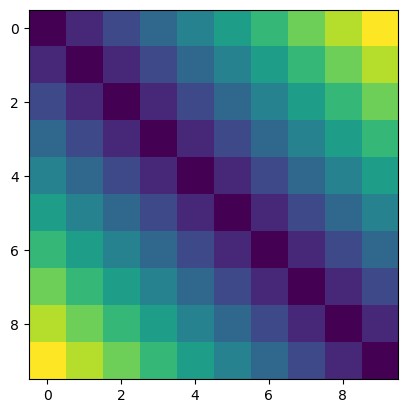

In [74]:
plt.imshow( jlinops.black_box_to_dense(T) )
plt.show()

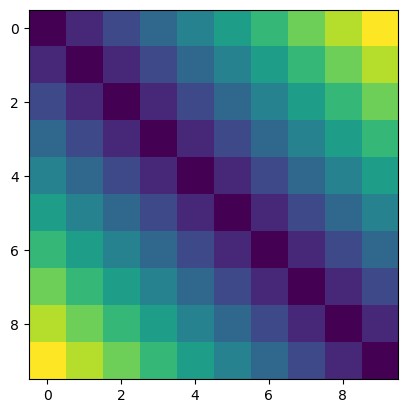

In [76]:
plt.imshow( sp_toeplitz(t) )
plt.show()

# Random Toeplitz

In [77]:

def random_toeplitz_matrix(n, which="matrix", symmetric=True):
    """Generates a random Toeplitz matrix.
    """
    
    # Draw random column vector
    col = np.random.normal(size=n)

    if not symmetric:
        row = np.random.normal(size=n)
        row[0] = col[0]
    else:
        row = None

    if which == "matrix":
        return sp_toeplitz(col, r=row)

    elif which == "operator":
        assert symmetric, "Currently supported only for symmetric matrices."
        return SymmetricToeplitzOperator(col)

    else:
        raise NotImplementedError


In [81]:
T = random_toeplitz_matrix(10, which="matrix", symmetric=False)

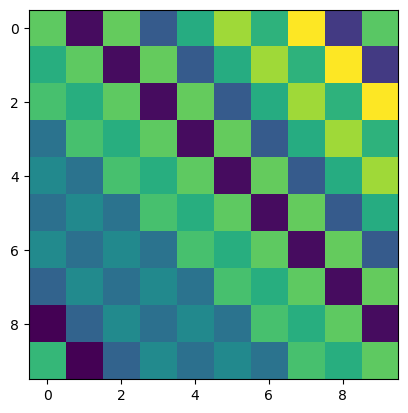

In [82]:
plt.imshow(T)
plt.show()

In [83]:
T = random_toeplitz_matrix(10, which="operator" )

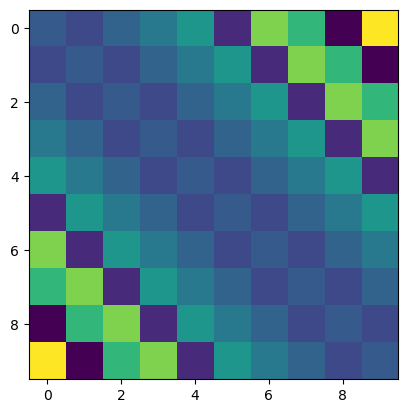

In [84]:
plt.imshow( jlinops.black_box_to_dense(T) )
plt.show()